In [1]:
import numpy as np
import math as mp
import pandas as pd

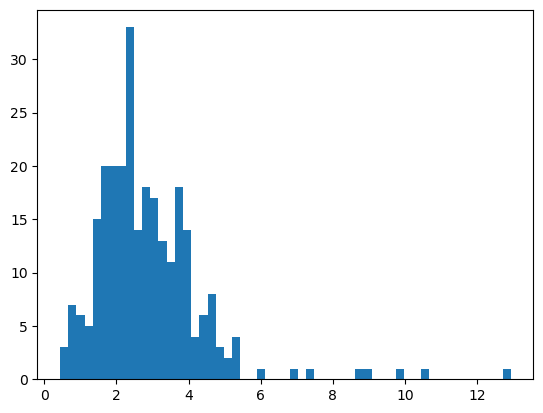

In [2]:
data=pd.read_csv('APP_data_usa_goods.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
data_tau=(data['invtCogsRatio']* 36.5/(30*0.1))
import matplotlib.pyplot as plt
plt.hist(data_tau,bins = 55)
plt.show()

In [3]:
sigma = 2
beta = 1 /( 1.0 +0.01)
beta1 =1/( (1.0 +0.01* np.exp(30/(36.5*0.9)))) 
beta_hh =  beta
W = 1

In [4]:
tau_diff = np.zeros(( 1000,1))
i = 0
for c in np.linspace(0, 0.99, 1000): 
    N = -(data_tau) - 1/np.log(beta*c) 
    tau1= -1/np.log(beta*c) - N
    tau1[tau1<0] = 0     
    tau2= -1/np.log(beta1*c) - N
    tau2[tau2<0] = 0    
    tau_diff[i] = np.mean(np.abs(tau1-tau2))
    i = i+1

/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_93874/1678760125.py:4: RuntimeWarning: divide by zero encountered in log
  N = -(data_tau) - 1/np.log(beta*c)
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_93874/1678760125.py:5: RuntimeWarning: divide by zero encountered in log
  tau1= -1/np.log(beta*c) - N
/var/folders/26/bmvk0hrd5xbgcvl_s6s42rf80000gn/T/ipykernel_93874/1678760125.py:7: RuntimeWarning: divide by zero encountered in log
  tau2= -1/np.log(beta1*c) - N


In [5]:
min_val = np.min(np.abs(tau_diff-1))
argmins = np.where(np.abs(tau_diff-1) == min_val)[0]

In [6]:
c_list = np.linspace(0, 0.99, 1000)
c=c_list[argmins]

In [7]:
N=-data_tau - 1/np.log(beta_hh*c) 
tau= -1/np.log(beta_hh*c) - N
tau[tau<0] = 0  
tau_floor = np.floor(tau)
tau_ceil = np.ceil(tau)
tprod_ceil=  (beta_hh*c)**tau_ceil * (tau_ceil + N)
tprod_floor=  (beta_hh*c)**tau_floor * (tau_floor + N)
tau[(tprod_ceil-tprod_floor)>0] = tau_ceil[(tprod_ceil-tprod_floor)>0]
tau[(tprod_ceil-tprod_floor)<0] = tau_floor[(tprod_ceil-tprod_floor)<0]
tau[tau<0] = 0  

tprod = (beta*c)**tau * (tau + N)
tprod_array = np.array([tprod])

In [8]:
import numpy as np

def euler_path_fixed_wages(
    i_path,
    demand_level,
    theta,
    *,
    a_path=None,         # optional log TFP path; default zeros
    beta_hh=0.99,
    phi=1.0,             # inverse Frisch
    phi_w=50.0,          # Rotemberg wage stickiness (higher => stickier)
    r_ss=None,           # steady-state real rate; default 1/beta - 1
    max_iter=500,
    tol=1e-10,
    relax=0.6,
    return_all=False,
):
    """
    Deterministic NK with flexible prices and ONLY wage rigidity (Rotemberg).
    You feed: nominal rate path i_t and demand (preference) shock path d_t.
    Optional: productivity path a_t (log TFP). Perfect-foresight solution.

    Equations (log deviations):
      y_t = c_t
      n_t = y_t - a_t
      mrs_t = σ c_t + φ n_t = (σ+φ) y_t - φ a_t
      Wage Rotemberg:
          φ_w π^w_t = (w_t - mrs_t) - β (w_{t+1} - mrs_{t+1}),  with  π^w_t = Δ w_t
      Flexible prices:
          p_t ∝ (w_t - a_t)  ⇒  π_t = π^w_t - Δ a_t
      Euler (IS) with demand shock d_t:
          c_t = c_{t+1} - (1/σ) * ( i_t - π_{t+1} - r_ss - d_t )

    Sign convention for demand_level:
      Positive demand_level[t] lowers the effective real rate (raises desired c_t).
    """
    i_path = np.asarray(i_path, dtype=float)
    d_path = np.asarray(demand_level, dtype=float)
    T = i_path.size
    assert d_path.size == T, "demand_level and i_path must have same length"

    if a_path is None:
        a_path = np.zeros(T, dtype=float)
    else:
        a_path = np.asarray(a_path, dtype=float)
        assert a_path.size == T, "a_path and i_path must have same length"

    if r_ss is None:
        r_ss = 1/beta_hh -1

    # --- helper: wage block for given y_t = c_t ---
    def _solve_wage_block(y, a):
        # mrs_t = (σ+φ) y_t - φ a_t
        mrs = (theta + phi) * y - phi * a
        dmrs = np.zeros(T)
        if T > 1:
            dmrs[1:] = mrs[1:] - mrs[:-1]
        # Tridiagonal system in u_t = w_t - mrs_t:
        #   β u_{t+1} + (φ_w - 1) u_t - φ_w u_{t-1} = - φ_w Δ mrs_t
        A = np.zeros((T, T))
        for t in range(T):
            if t > 0:
                A[t, t - 1] = -phi_w
            A[t, t] = (phi_w - 1.0)
            if t < T - 1:
                A[t, t + 1] = beta_hh
        
        b = -phi_w * dmrs
        u = np.linalg.solve(A, b)
        w = u + mrs
        piw = np.zeros(T)
        if T > 1:
            piw[1:] = w[1:] - w[:-1]
        return u, w, piw, mrs

    # --- initial guess for c: ignore inflation, include demand shock ---
    c = np.zeros(T + 1)
    for t in range(T - 1, -1, -1):
        c[t] = c[t + 1] - (1.0 / theta) * (i_path[t] - 0.0 - r_ss - d_path[t])
    c = c[:T]

    # --- fixed-point iterate: wages ⇒ π ⇒ Euler ⇒ c ---
    for _ in range(max_iter):
        u, w, piw, mrs = _solve_wage_block(c, a_path)
        da = np.zeros(T)
        if T > 1:
            da[1:] = a_path[1:] - a_path[:-1]
        pi = piw - da  # flexible-price inflation

        # Backward Euler with π_{t+1} and demand shock d_t
        c_new = np.zeros(T + 1)
        for t in range(T - 1, -1, -1):
            exp_pi_next = pi[t + 1] if t + 1 < T else 0.0
            c_new[t] = c_new[t + 1] - (1.0 / theta) * (i_path[t] - exp_pi_next - r_ss - d_path[t])
        c_new = c_new[:T]

        diff = np.max(np.abs(c_new - c))
        c = (1 - relax) * c + relax * c_new
        if diff < tol:
            break

    # --- final outputs ---
    u, w, piw, mrs = _solve_wage_block(c, a_path)
    da = np.zeros(T)
    if T > 1:
        da[1:] = a_path[1:] - a_path[:-1]
    pi = piw - da

    if return_all:
        return {
            "c": c, "pi": pi, "w": w, "piw": piw, "u": u, "mrs": mrs,
            "n": c - a_path,         # employment (since y=c and y=a+n)
            "y": c,                  # output
            "a": a_path,             # TFP
        }
    return c, pi

In [9]:
import numpy as np
import itertools

sequence_length = 3
r_choice = np.linspace(0, 0.02, 9)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(729, 3)


In [11]:
k=0
T = 50

deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, T)) 
for r in r_arrange: 
        

    # Example: fixed i=0, expected productivity sequence
    i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
    abar = np.zeros(T)
    eps = np.zeros(T)
    abar[0] = -0.01
    r_arrange_list = np.ones(T) *(1/(beta_hh)-1)
    r_arrange_list[0:sequence_length] = r_arrange[k]

    c, pi = euler_path_fixed_wages(r_arrange_list, abar, theta=1.0)
    deviation_gap[k] = np.sum((c )**2) 
    C_consumption[k, :len(c)] = c.flatten()
    k = k+1

In [12]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([204])

In [13]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [14]:
r_arrange[argmins_gap]

array([[0.005, 0.01 , 0.015]])

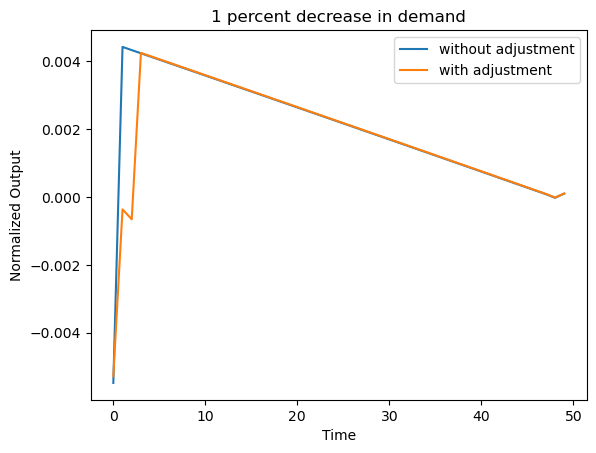

In [15]:


plt.plot( C_consumption[matches,].T, label='without adjustment')

plt.plot( C_consumption[argmins_gap,].T, label='with adjustment')
plt.legend()
plt.title('1 percent decrease in demand')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [218]:
import numpy as np
import itertools

sequence_length = 6
r_choice = np.linspace(0, 0.0125, 6)  # 6 values from 0 to 0.0125 inclusive

# Generate all possible combinations (Cartesian product)
all_combinations = list(itertools.product(r_choice, repeat=sequence_length))

# Convert to NumPy array
big_array = np.array(all_combinations)

print(big_array.shape)  # Should be (6^6, 6) = (46656, 6)

# Assign to r_arrange
r_arrange = big_array
size = r_arrange.shape[0]

(46656, 6)


In [128]:
import numpy as np

def euler_path_fixed_wages(
    i_path,
    a_path,
    theta,
    *,
    demand_level=None,   # <--- added
    beta_hh=0.99,
    phi=1.0,
    phi_w=50.0,
    r_ss=None,
    max_iter=500,
    tol=1e-10,
    relax=0.6,
    return_all=False,
):
    """
    Deterministic NK (no capital), flexible prices, ONLY wage stickiness (Rotemberg).
    You feed: nominal rate path i_t, log TFP path a_t, and demand shock d_t.
    We solve the coupled system for c/y and inflation with perfect foresight.

    Core equations (log deviations):
      y_t = c_t
      y_t = a_t + n_t  => n_t = y_t - a_t
      mrs_t = σ c_t + φ n_t = (σ+φ) y_t - φ a_t
      φ_w π^w_t = (w_t - mrs_t) - β (w_{t+1} - mrs_{t+1}),  with π^w_t = Δ w_t
      Flexible prices:  p_t = const + (w_t - a_t)  ⇒  π_t = π^w_t - Δa_t
      Euler (IS) with demand shock d_t:
         c_t = c_{t+1} - (1/σ) * ( i_t - π_{t+1} - r_ss - d_t )
    """
    i_path = np.asarray(i_path, dtype=float)
    a_path = np.asarray(a_path, dtype=float)
    T = i_path.size
    assert a_path.size == T, "a_path and i_path must have same length"

    if demand_level is None:
        d = np.zeros(T, dtype=float)
    else:
        d = np.asarray(demand_level, dtype=float)
        assert d.size == T, "demand_level and i_path must have same length"

    if r_ss is None:
        r_ss = 0.01  # keep your original default

    # ---- wage block helper ----
    def _solve_wage_block(y, a):
        # mrs_t = (σ+φ) y_t - φ a_t
        mrs = (theta + phi) * y - phi * a
        dmrs = np.zeros(T)
        if T > 1:
            dmrs[1:] = mrs[1:] - mrs[:-1]
        # β u_{t+1} + (φ_w - 1) u_t - φ_w u_{t-1} = - φ_w Δ mrs_t
        A = np.zeros((T, T))
        for t in range(T):
            if t > 0:
                A[t, t - 1] = -phi_w
            A[t, t] = (phi_w - 1.0)
            if t < T - 1:
                A[t, t + 1] = beta_hh
                # ... after you fill A and before solve ...

        b = -phi_w * dmrs
        u = np.linalg.solve(A, b)   # wage markup: u_t = w_t - mrs_t
        w = u + mrs                 # real wage
        piw = np.zeros(T)           # wage inflation
        if T > 1:
            piw[1:] = w[1:] - w[:-1]
        return u, w, piw, mrs

    # ---- initial guess for c: π=0, include demand shock d_t ----
    c = np.zeros(T + 1)
    for t in range(T - 1, -1, -1):
        exp_pi_next = 0.0
        c[t] = c[t + 1] - (1.0 / theta) * (i_path[t] - exp_pi_next - r_ss - d[t])
    c = c[:T]

    # ---- fixed-point: wages ⇒ π ⇒ Euler (with d_t) ⇒ c ----
    for _ in range(max_iter):
        u, w, piw, mrs = _solve_wage_block(c, a_path)
        da = np.zeros(T)
        if T > 1:
            da[1:] = a_path[1:] - a_path[:-1]
        pi = piw - da  # flexible-price inflation

        c_new = np.zeros(T + 1)
        for t in range(T - 1, -1, -1):
            exp_pi_next = pi[t + 1] if t + 1 < T else 0.0
            c_new[t] = c_new[t + 1] - (1.0 / theta) * (i_path[t] - exp_pi_next - r_ss - d[t])
        c_new = c_new[:T]

        diff = np.max(np.abs(c_new - c))
        c = (1 - relax) * c + relax * c_new
        if diff < tol:
            break

    # ---- final pass ----
    u, w, piw, mrs = _solve_wage_block(c, a_path)
    da = np.zeros(T)
    if T > 1:
        da[1:] = a_path[1:] - a_path[:-1]
    pi = piw - da

    if return_all:
        return {
            "c": c, "pi": pi, "w": w, "piw": piw,
            "u": u, "mrs": mrs, "n": c - a_path  # employment since y=c and y=a+n
        }
    return c, pi


In [129]:
k=0
T=30
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 30))
N_array = np.array(N)

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()
for r in r_arrange: 
        
    i_path = np.ones(T)*(1/(beta_hh)-1)   # fixed nominal rate
    abar = np.zeros(T)
    eps = np.zeros(T)

    interest_rate_list = np.ones((T,T)) * 0.01
    # Start with all rows = base

    n = len(r_arrange[k])
    r = np.asarray(r_arrange[k], dtype=float)
    fill = 0.01

    arr2d = np.full((n, n), fill, dtype=float)

    # Fill each row with the backward-looking rates
    for i in range(n):
        arr2d[i, :i+1] = r[i::-1]

    # Put into big matrix
    interest_rate_list[0:n, :n] = arr2d

    # Compute beta
    beta = 1.0 / (1.0 + interest_rate_list)

    cumprod_ext = np.ones((30,31))
    cumprod_ext[:,1:] = np.cumprod(beta,axis=1)
    beta_prod = cumprod_ext[:,tvals] 

    tprod_array = np.array((beta_prod * 0.9018018) * (((tvals + N_array))*np.ones((30,269)) ))
    prod_shock = np.ones((30,269))
    inside = 1/(tprod_array)**(sigma-1)
    A_prod = np.sum( inside,axis = 1)**(1/(sigma-1))

    i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[k]  
    abar = np.log(A_prod)  # log productivity sequence

    demand = np.zeros(T)
    dA = np.zeros(T)
    dA[1:] = abar[1:] - abar[:-1]

    demand[0] = -0.01  # initial demand shock
    c,pi = euler_path_fixed_wages(i_path, abar, theta=1.0,demand_level=demand)
    deviation_gap[k] = np.sum((c )**2) + np.sum(pi**2)  
    C_consumption[k, :len(c)] = c.flatten() 
    k = k+1

In [130]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [131]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([20439])

In [132]:
r_arrange[argmins_gap]

array([[0.005 , 0.0075, 0.01  , 0.0075, 0.01  , 0.0075]])

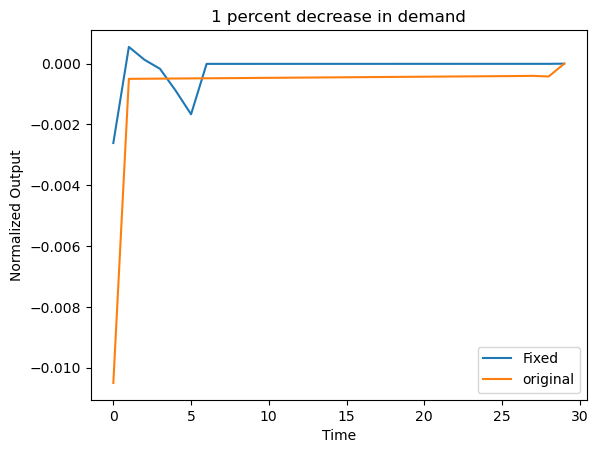

In [133]:
plt.plot( C_consumption[argmins_gap,].T, label='Fixed')
plt.plot( C_consumption[matches, ].T, label='original' )


plt.legend()
plt.title('1 percent decrease in demand')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()

In [134]:
import numpy as np

def find_duplicate_indices_per_row(arr, tol=0.0):
    """
    arr : (R, C) array
    tol : tolerance for considering two values equal (0.0 means exact match)

    Returns:
      list of length R; each item is a list of column indices that are in duplicate groups
    """
    dup_indices = []
    for row in arr:
        if tol > 0:
            # use tolerance
            idxs = []
            for i in range(len(row)):
                for j in range(i+1, len(row)):
                    if abs(row[i] - row[j]) <= tol:
                        idxs.extend([i, j])
            dup_indices.append(sorted(set(idxs)))
        else:
            # exact match
            vals, inv, counts = np.unique(row, return_inverse=True, return_counts=True)
            dups = np.where(counts > 1)[0]            # values that repeat
            cols = np.where(np.isin(inv, dups))[0]    # col indices of those values
            dup_indices.append(cols.tolist())
    return dup_indices

In [135]:
ccccc = 0.9018018

In [136]:
jjjjj=0
T=30
deviation_gap = np.zeros((size, 1))
C_consumption = np.zeros((size, 30))
N_array = np.array(N)

# Compute tprod using product of first tau betas
tau_int = tau.astype(int)    
tvals = tau_int.to_numpy()
for r in r_arrange: 

    interest_rate_list = np.ones((T,T)) * 0.01
    # Start with all rows = base

    n = len(r_arrange[jjjjj])
    r = np.asarray(r_arrange[jjjjj], dtype=float)
    fill = 0.01

    arr2d = np.full((n, n), fill, dtype=float)

    # Fill each row with the backward-looking rates
    for i in range(n):
        arr2d[i, :i+1] = r[i::-1]

    # Put into big matrix
    interest_rate_list[0:n, :n] = arr2d

    # Compute beta
    beta = 1.0 / (1.0 + interest_rate_list)* ccccc

    cumprod_ext = np.ones((T,T+1))
    cumprod_ext[:,1:] = np.cumprod(beta,axis=1)
    tau_list = np.linspace(0, T, T+1)
    time_list_stuff = tau_list*np.ones((T,T+1))
    tprod = (cumprod_ext )[:, :, None] * (time_list_stuff[:, :, None] + np.array(N)[None, None, :])
    tprod_array = np.array(tprod)

    # idx_max will be (30, 269), giving the best column index for each (i, k)
    idx_max = np.argmax(tprod_array, axis=1)  # axis=1 corresponds to the 31 columns

    # Now gather the max values
    max_vals = np.max(tprod, axis=1)    # shape (30, 269)

    tau_best = idx_max


    time_period=np.linspace(0,29,30)*np.ones_like(tau_best).T
    tau_timing= tau_best.T + time_period
    Productivity = np.zeros((len(tau_timing), 30))
    Productivity = max_vals.T
    shocky = 1


    duplicates = find_duplicate_indices_per_row(tau_timing)
    for i in range(len(tau_timing)):
        k = 0
        for j in tau_timing[i,tau_timing[i,:]<30]:
            if k in duplicates[i]:
                for kkk in duplicates[i]:
                    if tau_timing[i,kkk] == j:
                        if k == 0:
                            big=shocky* max_vals[k,i] > max_vals[kkk,i]
                            if big == True:
                                Productivity[i,int(j)] = shocky* max_vals[k,i]
                                Productivity[i,int(tau_timing[i,kkk])] = 0
                            else:
                                Productivity[i,int(j)] = 0
                        else:
                            big= max_vals[k,i] > max_vals[kkk,i]
                            if big == True:
                                Productivity[i,int(tau_timing[i,kkk])] = 0
                            else:
                                Productivity[i,int(j)] = 0
            else:
                if k ==0:
                    Productivity[i,int(j)] = shocky* max_vals[k,i]
            k = k+1
    A_prod = 1/np.sum( (Productivity)**(sigma-1),axis = 0)**(1/(sigma-1))
    
    i_path = np.ones(T)*(1/(beta_hh)-1)  # fixed nominal rate
    i_path[0:sequence_length] = r_arrange[jjjjj]  
    abar = np.log(A_prod)  # log productivity sequence
    demand = np.zeros(T)
    dA = np.zeros(T)
    dA[1:] = abar[1:] - abar[:-1]

    demand[0] = -0.01  # initial demand shock
    c,pi = euler_path_fixed_wages(i_path, abar, theta=1.0,demand_level=demand)
    
    deviation_gap[jjjjj] = np.sum((c )**2)  + np.sum((pi)**2)
    C_consumption[jjjjj, :len(c)] = c.flatten() 
    jjjjj = jjjjj+1

In [253]:
target = np.array([0.01]*sequence_length)

matches = np.all(np.isclose(r_arrange, target), axis=1)

In [254]:
argmins_gap = np.where(deviation_gap == np.min(deviation_gap))[0]
argmins_gap

array([40])

In [255]:
r_arrange[argmins_gap]

array([[0.  , 0.01, 0.01]])

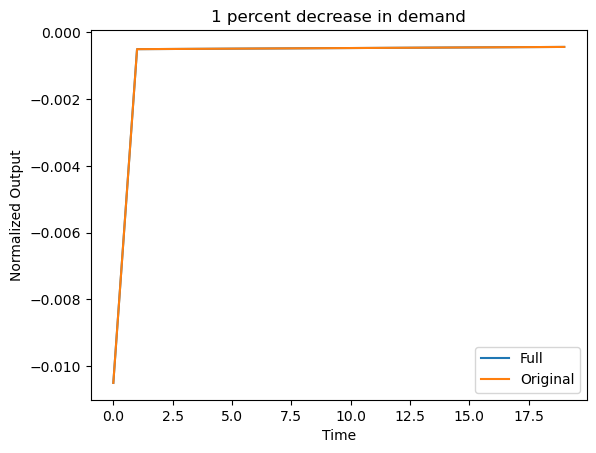

In [140]:
plt.plot( C_consumption[argmins_gap, :20].T, label='Full')
plt.plot( C_consumption[matches, :20].T, label='Original' )

plt.legend()
plt.title('1 percent decrease in demand')
plt.xlabel('Time')
plt.ylabel('Normalized Output') 
plt.show()